### RNN on a Time Series

For these examples we're using data from the Federal Reserve Economic Database (FRED) concerning Sales of
Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2019 (325
records).

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

### Perform standard imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
# This relates to plotting datatime values with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Load the dataset

We'll take advantage of pandas' built-in DatetimeIndex by passing parse_dates=True

In [3]:
df = pd.read_csv('TimeSeriesData/Alcohol_Sales.csv', index_col=0, parse_dates=True)

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
len(df)

325

In [6]:
df.isnull().sum()

S4248SM144NCEN    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   S4248SM144NCEN  325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [9]:
df.dropna(inplace=True)

In [10]:
len(df)

325

### Plotting time series data

We can add titles, axis labels, and other features to the plot.
We're going to tighten the x-axis to fit the width of the actual data with
plt.autoscale(axis='x',tight=True).
Alternatively you could set your own limits with plt.xlim(pd.Timestamp('1992-01-01'),
pd.Timestamp('2019-01-01')) or some other values.

<AxesSubplot:xlabel='DATE'>

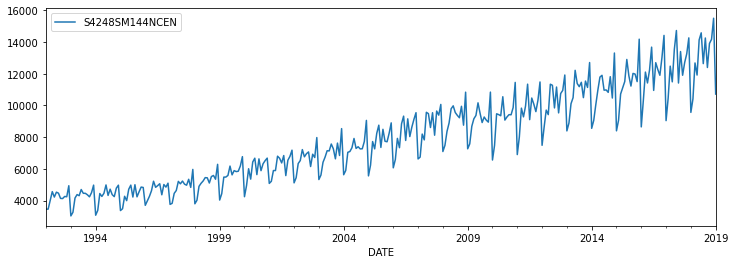

In [11]:
df.plot(figsize=(12,4))

### Prepare the data

In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall
between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set.
Finally, we'll forecast into an unknown future.

In [12]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

In [14]:
# Create a test size
test_size = 12 # number of months

# Create a train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [16]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

## Normalize the data


We can use scikit-learn to do this, with sklearn.preprocessing.MinMaxScaler()

*NOTE:* We only want to normalize the training set to avoid data leakage. If we include the test set then the higher
average values of the test set could become part of the signal in the training set. There's a good article on data
leakage here.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted
values so that we can compare them to the actual test data

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [19]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [20]:
train_norm.min()

-1.0

In [21]:
train_norm.max()

1.0

### Prepare data for LSTM

Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of
samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [22]:
# Convert train norm from numpy array to tensor
train_norm=torch.FloatTensor(train_norm).view(-1)
window_size = 12

# Define function to create seq/label tuples
def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    return out

In [23]:
# Apply the input_data function to train_norm
train_data = input_data(train_norm, window_size)

In [24]:
len(train_data)

301

In [25]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [26]:
train_data[1]

(tensor([-0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109, -0.8128,
         -0.7901, -0.7933, -0.6743, -1.0000]),
 tensor([-0.9607]))

### Define the model

This time we'll use an LSTM layer of size (1,100).

In [44]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
            # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
            # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
            # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
        torch.zeros(1,1,self.hidden_size))
        
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
        seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1] # we only want the last value

### Instantiate the model, define loss and optimization functions

In [50]:
torch.manual_seed(101)
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.1)
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [51]:
for i in model.parameters():
    print(i.numel())

400
40000
400
400
100
1


## Train the model

In [52]:
epochs = 10

import time
start_time = time.time()

for epoch in range(epochs):
    
      # extract the sequence & label from the training data
    for seq, y_train in train_data:
         # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
      # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.12855078
Epoch:  2 Loss: 0.37465429
Epoch:  3 Loss: 0.01964457
Epoch:  4 Loss: 0.40117490
Epoch:  5 Loss: 0.34057599
Epoch:  6 Loss: 0.94757080
Epoch:  7 Loss: 0.02645668
Epoch:  8 Loss: 0.13795529
Epoch:  9 Loss: 0.04287086
Epoch: 10 Loss: 0.18217674

Duration: 484 seconds


### Run predictions and compare to known test set

In [54]:
future = 12
# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()
# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                  torch.zeros(1,1,model.hidden_size))
    preds.append(model(seq).item())

### Invert the normalization

We want to compare our test predictions to the original data, so we need to undo the previous normalization
step. Note that inverse_transform uses the most recently applied parameters; we can rescale based on the
test data, but not on the previous training data.

In [55]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1)
)
true_predictions

array([[12501.34199783],
       [13979.33684799],
       [12915.96255252],
       [14971.25695348],
       [15422.84216249],
       [12687.54316339],
       [14926.75153756],
       [13169.45737967],
       [14249.08747634],
       [14497.20182297],
       [15256.24530351],
       [10871.13449714]])

### Plot the results

Our original data contains a datetime index, but our predicted values do not. We can create a range of dates
using NumPy that are spaced one month apart using dtype='datetime64[M]', and then store them with day
values to match our dataset with .astype('datetime64[D]').

In [56]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

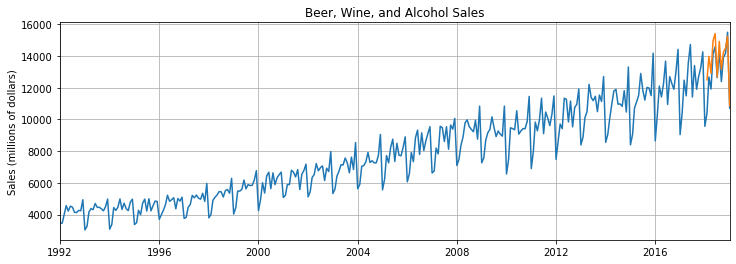

In [57]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

### Forecast into an unknown future

This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.